# Teste Prático para Desenvolvedor em Inteligência Artificial com Imagens
### Instruções:
- O teste consiste em várias tarefas práticas relacionadas ao processamento de imagens e
aprendizado profundo.
- Complete cada tarefa seguindo as instruções fornecidas.
-  Sinta-se à vontade para usar a internet e consultar a documentação sempre que necessário.
- Prazo para completar o teste: 1 dia.

In [1]:
# Importação do dataset

import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')

100%|██████████| 346M/346M [00:10<00:00, 33.1MB/s]

Extracting files...


Data source import complete.


In [2]:
# Importação de bibliotecas padrão
import os
import glob as gb

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Google Colab imports
from google.colab import files

### Download dos dados

In [3]:
def download_kaggle_dataset(kaggle_data_path, is_competition=False):
    """
    Baixa e extrai um conjunto de dados do Kaggle.

    Args:
        kaggle_data_path (str): Caminho do conjunto de dados no Kaggle.
        is_competition (bool): Define se o download é de uma competição (True) ou um dataset regular (False).
    """
    dataset_name = kaggle_data_path.split("/")[-1]

    !pip install -q kaggle

    files.upload()

    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    if is_competition:
        !kaggle competitions download -c {kaggle_data_path}
    else:
        !kaggle datasets download -d {kaggle_data_path}

    !unzip -q {dataset_name}.zip -d {dataset_name}
    !rm {dataset_name}.zip


def check_and_download_dataset(kaggle_path, colab_path):
    """
    Verifica a presença do conjunto de dados no Kaggle ou no Google Colab,
    baixando-o se necessário.

    Args:
        kaggle_path (str): Caminho no Kaggle onde o conjunto de dados está armazenado.
        colab_path (str): Caminho no Colab onde o conjunto de dados pode estar disponível.

    Returns:
        str: Caminho onde o conjunto de dados está localizado.
    """
    try:
        if gb.glob(pathname=kaggle_path + "*"):
            print("Dataset já disponível no Kaggle.")
            return kaggle_path

        elif gb.glob(pathname=colab_path + "*"):
            print("Dataset já baixado no Colab.")
            return colab_path

        raise FileNotFoundError

    except FileNotFoundError:
        import google.colab
        print("Executando no Google Colab. Baixando o conjunto de dados do Kaggle...")
        download_kaggle_dataset("puneet6060/intel-image-classification")
        return colab_path


In [4]:
kaggle_path = "/kaggle/input/intel-image-classification/"
colab_path = "/content/intel-image-classification/"
MAIN_PATH = check_and_download_dataset(kaggle_path, colab_path)

train_path = MAIN_PATH + "seg_train/seg_train/"
test_path = MAIN_PATH + "seg_test/seg_test/"
pred_path = MAIN_PATH + "seg_pred/seg_pred/"

Running in Google Colab


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 99% 342M/346M [00:09<00:00, 40.2MB/s]
100% 346M/346M [00:09<00:00, 38.9MB/s]


### Tarefa 1: Carregamento e Visualização de Imagens
1. Baixe um conjunto de imagens de exemplo (por exemplo, fotos de animais, frutas, veículos,
etc.).
2. Escreva um script em Python para carregar e visualizar algumas dessas imagens usando
uma biblioteca de processamento de imagens, como OpenCV ou PIL.

In [ ]:
def load_images(directory, max_images=None):
    """
    Load images from a specified directory.

    Args:
        directory (str): Path to the directory containing subdirectories of images.
        max_images (int, optional): Maximum number of images to load per category. Defaults to None.

    Returns:
        tuple: Lists of images and their corresponding labels.
    """
    images = []
    labels = []

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        if os.path.isdir(subdir_path):
            print(f"Carregando imagens da categoria: {subdir}")

            for i, image_name in enumerate(os.listdir(subdir_path)):
                if max_images is not None and i >= max_images:
                    break

                image_path = os.path.join(subdir_path, image_name)
                image = cv2.imread(image_path)

                if image is not None:
                    images.append(image)
                    labels.append(subdir)
                else:
                    print(f"Erro ao carregar a imagem: {image_name}")

    return images, labels


def display_images(images, labels, max_images=None):
    """
    Display loaded images with their corresponding labels.

    Args:
        images (list): List of loaded images.
        labels (list): List of labels corresponding to each image.
        max_images (int, optional): Maximum number of images to display. Defaults to None.
    """
    print("Visualizando imagens:")

    for i, image in enumerate(images):
        if max_images is not None and i >= max_images:
            break

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.title(f"Categoria: {labels[i]}")
        plt.axis("off")
        plt.show()


Carregando imagens da categoria: glacier
Carregando imagens da categoria: sea
Carregando imagens da categoria: mountain
Carregando imagens da categoria: forest
Carregando imagens da categoria: buildings
Carregando imagens da categoria: street
Carregando imagens da categoria: glacier
Carregando imagens da categoria: sea
Carregando imagens da categoria: mountain
Carregando imagens da categoria: forest
Carregando imagens da categoria: buildings
Carregando imagens da categoria: street
Visualizando imagens:


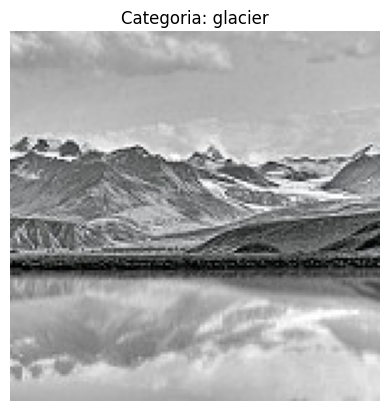

In [5]:
imagens_train, labels_train = load_images(train_path)
imagens_test, labels_test = load_images(test_path)

display_images(imagens_train, labels_train, max_imagens=1)



### Tarefa 2: Pré-processamento de Imagens

Utilizando o conjunto de imagens carregado na Tarefa 1, realize as seguintes operações de pré-
processamento:

1. Redimensione todas as imagens para uma resolução específica, por exemplo, 224x224
pixels.
2. Normalize os valores dos pixels para o intervalo [0, 1].
3. Converta as imagens para o formato adequado para alimentação em modelos de
aprendizado profundo (por exemplo, numpy arrays para TensorFlow ou PyTorch).

In [ ]:
def preprocess_images(images, target_size=(224, 224)):
    """
    Preprocess images by resizing and normalizing.

    Args:
        images (list): List of images to preprocess.
        target_size (tuple): Target size to resize each image.

    Returns:
        np.ndarray: Array of processed images.
    """
    processed_images = []

    for image in images:
        resized_image = cv2.resize(image, target_size)
        normalized_image = resized_image / 255.0
        image_array = np.array(normalized_image, dtype=np.float32)
        processed_images.append(image_array)

    return np.array(processed_images)


def calculate_average_image_size(images):
    """
    Calculate the average size of images, along with the smallest and largest dimensions.

    Args:
        images (list): List of images.

    Returns:
        tuple: Average width, average height, smallest dimension, largest dimension.
    """
    widths = []
    heights = []

    for image in images:
        height, width = image.shape[:2]
        widths.append(width)
        heights.append(height)

    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    min_dimension = min(min(widths), min(heights))
    max_dimension = max(max(widths), max(heights))

    return avg_width, avg_height, min_dimension, max_dimension


In [10]:
largura_media_train, altura_media_train, menor_dimensao_train, maior_dimensao_train = calculate_average_image_size(imagens_train)
largura_media_test, altura_media_test, menor_dimensao_test, maior_dimensao_test = calculate_average_image_size(imagens_test)

print("Imagens de Treino:")
print("Largura média:", largura_media_train)
print("Altura média:", altura_media_train)
print("Menor dimensão:", menor_dimensao_train)
print("Maior dimensão:", maior_dimensao_train)

print("\nImagens de Teste:")
print("Largura média:", largura_media_test)
print("Altura média:", altura_media_test)
print("Menor dimensão:", menor_dimensao_test)
print("Maior dimensão:", maior_dimensao_test)

Imagens de Treino:
Largura média: 150.0
Altura média: 149.90872167592988
Menor dimensão: 76
Maior dimensão: 150

Imagens de Teste:
Largura média: 150.0
Altura média: 149.90333333333334
Menor dimensão: 72
Maior dimensão: 150


In [6]:
X_train = preprocess_images(imagens_train, target_size=(100, 100))
X_test = preprocess_images(imagens_test, target_size=(100, 100))

### Tarefa 3: Classificação de Imagens com Redes Neurais Convolucionais (CNN)
Desenvolva um modelo de classificação de imagens utilizando uma arquitetura de Rede Neural
Convolucional (CNN). Realize as seguintes tarefas:
1. Divida seu conjunto de dados em conjuntos de treinamento e teste.
2. Projete e treine uma CNN usando uma biblioteca de aprendizado profundo, como
TensorFlow ou PyTorch.
3. Avalie o desempenho do modelo usando os dados de teste. Calcule a acurácia do modelo.
4. Dado uma nova imagem, utilize o modelo treinado para prever sua classe.

In [ ]:
def create_cnn_model(input_shape):
    """
    Create a Convolutional Neural Network (CNN) model for image classification.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels)

    Returns:
        Sequential: Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def predict_image_class(image_path, model, label_encoder, target_size=(100, 100)):
    """
    Predict the class of a new image using a trained model.

    Args:
        image_path (str): Path to the image file.
        model (Sequential): Trained CNN model for predictions.
        label_encoder (LabelEncoder): Encoder to decode predicted class labels.
        target_size (tuple): Target size for resizing the image.

    Returns:
        str: Predicted class label.
    """
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size) / 255.0
    image_array = np.expand_dims(resized_image, axis=0)
    prediction = model.predict(image_array)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_class[0]


In [7]:
le = LabelEncoder()
labels_encoded_train = le.fit_transform(labels_train)
labels_encoded_test = le.transform(labels_test)

In [11]:
y_train = to_categorical(labels_encoded_train)
y_test = to_categorical(labels_encoded_test)

In [13]:
input_shape = (100, 100, 3)
cnn_model = create_cnn_model(input_shape)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Treinamento do modelo
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Métricas
loss, accuracy = modelo.evaluate(X_test, y_test)
print(f"Acurácia do modelo: {accuracy:.2f}")

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 327s 739ms/step - accuracy: 0.4483 - loss: 1.3323 - val_accuracy: 0.6813 - val_loss: 0.8878
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 362s 694ms/step - accuracy: 0.6720 - loss: 0.8742 - val_accuracy: 0.7657 - val_loss: 0.6704
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 304s 692ms/step - accuracy: 0.7342 - loss: 0.7316 - val_accuracy: 0.7790 - val_loss: 0.6202
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 323s 694ms/step - accuracy: 0.7835 - loss: 0.6159 - val_accuracy: 0.7923 - val_loss: 0.5930
Epoch 5/10
382/439 ━━━━━━━━━━━━━━━━━━━━ 37s 665ms/step - accuracy: 0.8072 - loss: 0.5424

1/1 [==============================] - 0s 26ms/step


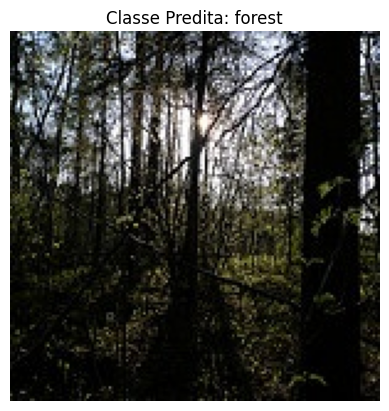

In [ ]:
## Previsão

test_image = "/content/intel-image-classification/seg_pred/seg_pred/10261.jpg"
cnn_prediction = predict_image_class(test_image, cnn_model)
image = cv2.imread(test_image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Classe Predita: {cnn_prediction}")
plt.axis('off')
plt.show()


##### Armazenando o modelo

In [ ]:
save_dir = "models/cnn"

os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "cnn_model.h5")

cnn_model.save(model_path)

print(f"Modelo salvo em: {model_path}")

Modelo salvo em: models/cnn/modelo_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Tarefa 4: Transfer Learning
Utilize uma rede neural pré-treinada (por exemplo, VGG, ResNet, Inception) e realize transfer
learning para treinar um classificador em seu conjunto de dados. Realize as seguintes tarefas:
1. Carregue o modelo pré-treinado e remova a camada de classificação final.
2. Adicione uma nova camada de classificação adequada para seu conjunto de dados.

3. Treine apenas os parâmetros da nova camada de classificação, mantendo os pesos das
camadas pré-treinadas fixos.
4. Avalie o desempenho do modelo usando os dados de teste.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
output_layer = Dense(units=6, activation="softmax")(x)

transfer_model = Model(inputs=base_model.input, outputs=output_layer)


In [ ]:
from tensorflow.keras.optimizers import Adam

transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

history = transfer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
439/439 [==============================] - 81s 183ms/step - loss: 0.8532 - accuracy: 0.7437 - val_loss: 0.5596 - val_accuracy: 0.8043
Epoch 2/10
439/439 [==============================] - 80s 182ms/step - loss: 0.5039 - accuracy: 0.8240 - val_loss: 0.4753 - val_accuracy: 0.8247
Epoch 3/10
439/439 [==============================] - 80s 181ms/step - loss: 0.4461 - accuracy: 0.8425 - val_loss: 0.4326 - val_accuracy: 0.8440
Epoch 4/10
439/439 [==============================] - 80s 183ms/step - loss: 0.4174 - accuracy: 0.8522 - val_loss: 0.4185 - val_accuracy: 0.8457
Epoch 5/10
439/439 [==============================] - 80s 183ms/step - loss: 0.3983 - accuracy: 0.8594 - val_loss: 0.4015 - val_accuracy: 0.8553
Epoch 6/10
439/439 [==============================] - 80s 183ms/step - loss: 0.3826 - accuracy: 0.8636 - val_loss: 0.3944 - val_accuracy: 0.8550
Epoch 7/10
439/439 [==============================] - 79s 181ms/step - loss: 0.3694 - accuracy: 0.8679 - val_loss: 0.3862 - val_ac

In [ ]:
# Métricas
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")


94/94 [==============================] - 14s 150ms/step - loss: 0.3714 - accuracy: 0.8687
Acurácia no conjunto de teste: 0.87


1/1 [==============================] - 0s 155ms/step


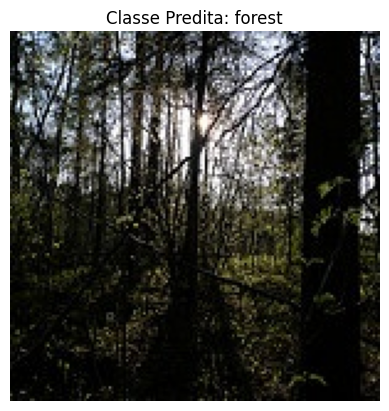

In [ ]:
second_test_image = "/content/intel-image-classification/seg_pred/seg_pred/10261.jpg"
transfer_prediction = predict_image_class(second_test_image, transfer_model)
image = cv2.imread(second_test_image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Classe Predita: {transfer_prediction}")
plt.axis('off')
plt.show()

In [ ]:
save_dir = "models/transfer"

os.makedirs(save_dir, exist_ok=True)

transfer_model_path = os.path.join(save_dir, "transfer_model.h5")

transfer_model.save(transfer_model_path)

print(f"Modelo salvo em: {transfer_model_path}")

Modelo salvo em: models/transfer/modelo_transfer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
